<a href="https://colab.research.google.com/github/anjurgupta/Energy-Lab-Codes/blob/main/Energy_Lab_5_Heat_Exchanger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Section 1: Import Required Libraries**

*We will start by importing the Python libraries that help us build and train machine learning models, handle data, and create plots for visualization.*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import preprocessing layers needed
from tensorflow.keras.layers import Normalization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import datetime
from google.colab import files

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

**Section 2: Upload and Load Dataset**

*In this step, we will upload a dataset into our Colab environment and load it into Python. After that, we’ll take a quick look at the data to understand what it contains.*

In [3]:
uploaded = files.upload()

# Check the exact uploaded filename
print(uploaded.keys())

# Use the actual key to read CSV
filename = list(uploaded.keys())[0]  # take the first uploaded file
data = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving heat_exchanger_100.csv to heat_exchanger_100.csv
dict_keys(['heat_exchanger_100.csv'])


**Section 3: Define Inputs and Outputs**

*Now, we will identify the input features (the data the model will use to make predictions) and the output labels (what we want the model to predict). This is an important step for setting up a supervised machine learning task.*

In [4]:
numeric_inputs = ["Th(in)", "Th(out)", "Tc(in)", "Tc(out)", "Rhoh", "Rhoc", "V%h", "V%c"]
output_cols = ["UNTU", "ULMTD"]

**Section 4: Split Data into Training and Test Sets**

*Next, we will divide our dataset into training and testing sets. The training set is used to teach the model, while the testing set is used to see how well the model performs on new, unseen data. This helps us evaluate the model’s accuracy and reliability.*

In [5]:
# --- Split dataset into training (80%) and testing (20%) ---
train_dataset = data.sample(frac=0.8, random_state=42)
test_dataset = data.drop(train_dataset.index)

**Section 5: Normalize Data**

*Neural networks work better when all input features are on a similar scale. Normalization rescales the data so that values are neither too big nor too small. This helps the model learn faster, converge more reliably, and avoid giving more importance to features just because they have larger numbers.*

In [6]:
# --- Training stats for numeric normalization ---
train_stats = train_dataset[numeric_inputs].describe().transpose()

# --- Normalize numeric features ---
def normalize_numeric(df):
    return (df - train_stats['mean']) / train_stats['std']

normed_train_data = normalize_numeric(train_dataset[numeric_inputs])
normed_test_data = normalize_numeric(test_dataset[numeric_inputs])

# --- Separate labels ---
train_labels = train_dataset[output_cols]
test_labels = test_dataset[output_cols]

# --- Display normalized and processed data ---
print("Processed train data (first 5 rows):")
print(normed_train_data.head())
print("\nProcessed test data (first 5 rows):")
print(normed_test_data.head())

Processed train data (first 5 rows):
      Th(in)   Th(out)    Tc(in)   Tc(out)      Rhoh      Rhoc       V%h  \
83  0.049102  0.814508  1.046347  1.115652 -0.674825 -1.302512  0.217428   
53  1.669344 -2.711939 -1.733729  0.560712  0.014241 -1.580636  0.363336   
70  1.140874  0.337130  0.462682  0.893810 -0.214059  2.095472 -0.709694   
45 -0.994097 -1.103128 -0.385563 -0.969459  1.249974  1.047062 -0.564292   
44 -0.159538 -0.859065 -1.101518 -0.919215  0.746565  1.098139 -0.824865   

         V%c  
83 -1.307991  
53 -1.490203  
70  0.599847  
45  1.178940  
44  0.930247  

Processed test data (first 5 rows):
      Th(in)   Th(out)    Tc(in)   Tc(out)      Rhoh      Rhoc       V%h  \
1  -0.157700  0.558111  0.453603  1.058058  0.904626  1.715690 -1.630789   
2  -1.273579  1.991081  0.246419  0.497444 -0.314011  2.442300  0.396031   
14  0.406146 -1.011469  0.137636 -3.099024 -0.079443 -0.105944  0.632124   
20 -1.371321  1.033407  0.645631 -1.022006 -0.856633  0.464950 -1.898280   

**Section 6: Build the Model**

*Now we will create our neural network. A neural network is made up of layers of neurons that process the input data. Each layer uses an activation function to help the network learn complex patterns. We’ll define the input layer (which takes our features), any hidden layers (which process the information), and the output layer (which makes predictions).*

In [7]:
# Number of inputs and outputs
num_inputs = normed_train_data.shape[1]  # should be 8
num_outputs = train_labels.shape[1]      # 2 outputs: UNTU, ULMTD

# Define the model
heat_exchanger_model = keras.Sequential([
    layers.Input(shape=(num_inputs,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_outputs)  # 2 outputs
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
heat_exchanger_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

heat_exchanger_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,026 (35.26 KB)

 Trainable params: 9,026 (35.26 KB)

 Non-trainable params: 0 (0.00 B)

**Section 7: Define Callback and Training Parameters**

*Before training the model, we define training parameters like the number of epochs (how many times the model will see the full dataset) and callbacks (tools that help monitor or control training, like stopping early if the model stops improving). These settings help the model train efficiently and avoid overfitting.*

In [8]:
# Callback to print progress during training
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

**Section 8: Example Prediction Before Training**

*Before we train the model, we can make a test prediction using random, untrained weights. This shows that initially, the model’s predictions are basically random and not accurate. It helps you understand how much the model improves after training.*

In [9]:
# Take a small batch of examples
example_batch = normed_train_data.head(5).values

# Make predictions
example_result = heat_exchanger_model.predict(example_batch)

print("Example predictions (UNTU and ULMTD for 5 samples):")
print(example_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Example predictions (UNTU and ULMTD for 5 samples):
[[-0.188  0.222]
 [-0.322  0.313]
 [-0.374  0.271]
 [-0.349  0.417]
 [-0.311  0.384]]


**Section 9: Setup TensorBoard**

*TensorBoard is a tool that lets us visualize and monitor our model’s training in real time. We can track metrics like loss and accuracy, see how the model improves over epochs, and spot problems early. Setting it up helps us understand what’s happening inside the neural network as it learns.*

In [10]:
# Set up TensorBoard logging
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

**Section 10: Train the Model**

*Now we will train (fit) the model on our data. During training, the model learns the patterns in the input features to make better predictions. We can also use a validation split to check the model’s performance on unseen data while training, and callbacks to monitor progress or stop training early if needed. This step is where the model actually “learns.”*

In [11]:
history = heat_exchanger_model.fit(
    normed_train_data,         # numeric input features
    train_labels.values,       # corresponding outputs (UNTU, ULMTD)
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[tensorboard_callback, PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

**Section 11: Plot Training History**

*After training, we can visualize the model’s learning curves using metrics like MAE (Mean Absolute Error) and MSE (Mean Squared Error). These plots show how the model’s predictions improve over time and help us understand if the model is learning well or if it might be overfitting.*

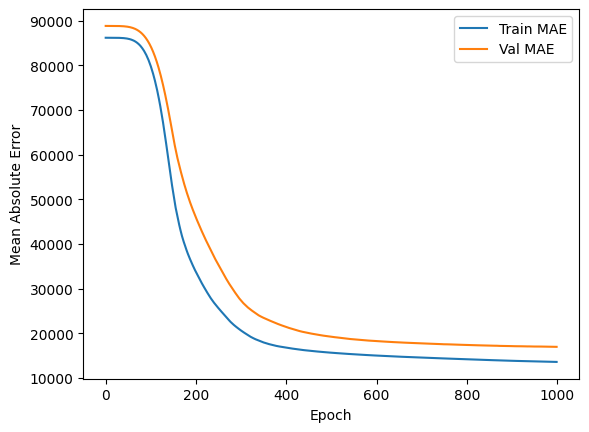

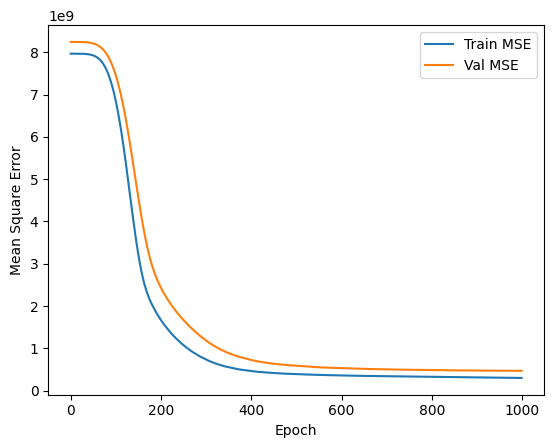

In [12]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # MAE
    plt.figure()
    plt.plot(hist['epoch'], hist['mae'], label='Train MAE')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

    # MSE
    plt.figure()
    plt.plot(hist['epoch'], hist['mse'], label='Train MSE')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

plot_history(history)

**Section 12: Test Predictions and Scatter Plot**

*Finally, we will use the model to make predictions on the test data and compare them to the actual values. We can create a scatter plot to visualize how close the predictions are to the true values. This helps us see the model’s performance in a clear, visual way.*

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


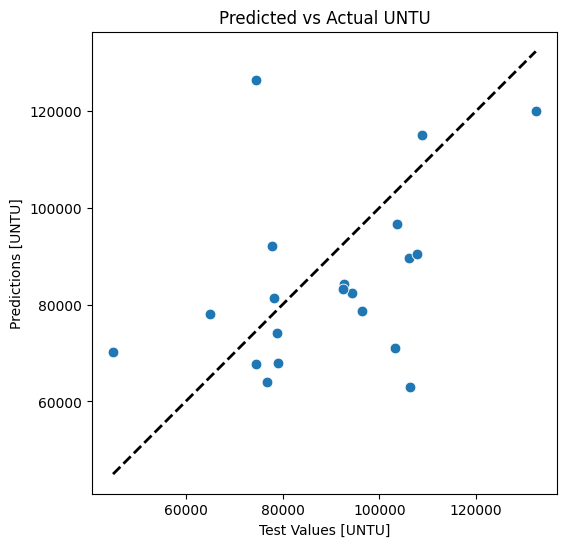

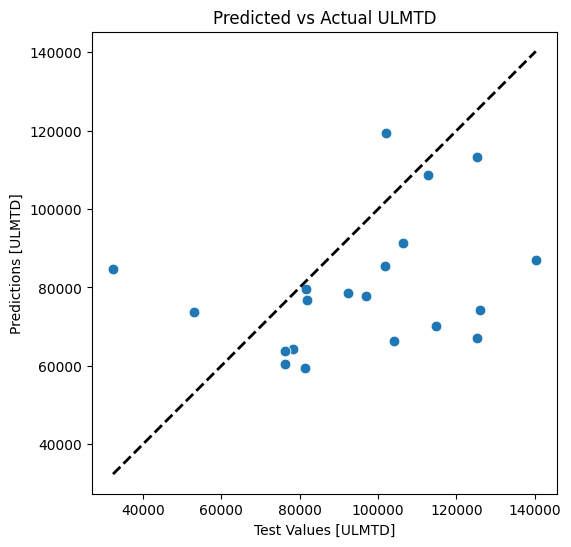

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on test data
test_predictions = heat_exchanger_model.predict(normed_test_data.values)

# Combine predictions with actual values for plotting
plot_df = test_labels.copy()
plot_df['UNTU_pred'] = test_predictions[:, 0]
plot_df['ULMTD_pred'] = test_predictions[:, 1]

# --- Plot UNTU ---
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='UNTU',
    y='UNTU_pred',
    data=plot_df,
    s=60
)
plt.xlabel("Test Values [UNTU]")
plt.ylabel("Predictions [UNTU]")
plt.title("Predicted vs Actual UNTU")
plt.axis('equal')
min_val = min(plot_df['UNTU'].min(), plot_df['UNTU_pred'].min())
max_val = max(plot_df['UNTU'].max(), plot_df['UNTU_pred'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.show()

# --- Plot ULMTD ---
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='ULMTD',
    y='ULMTD_pred',
    data=plot_df,
    s=60
)
plt.xlabel("Test Values [ULMTD]")
plt.ylabel("Predictions [ULMTD]")
plt.title("Predicted vs Actual ULMTD")
plt.axis('equal')
min_val = min(plot_df['ULMTD'].min(), plot_df['ULMTD_pred'].min())
max_val = max(plot_df['ULMTD'].max(), plot_df['ULMTD_pred'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.show()

**Section 13: Prediction Error Histograms**

*We can also look at histograms of the prediction errors (the differences between predicted and actual values). This helps us see where the model is making bigger mistakes and understand its strengths and weaknesses for each output.*

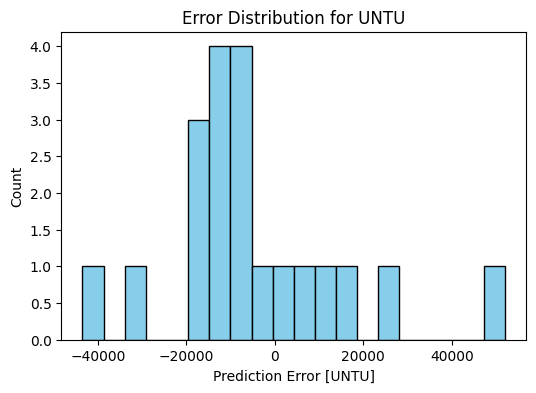

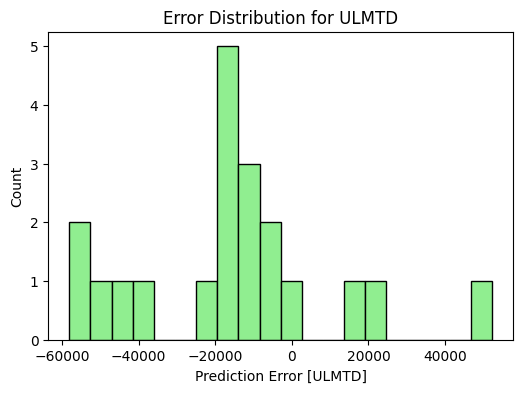

In [14]:
# Compute prediction errors
errors_untu = test_predictions[:, 0] - test_labels['UNTU'].values
errors_ulmtd = test_predictions[:, 1] - test_labels['ULMTD'].values

# --- Error histogram for UNTU ---
plt.figure(figsize=(6,4))
plt.hist(errors_untu, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error [UNTU]")
plt.ylabel("Count")
plt.title("Error Distribution for UNTU")
plt.show()

# --- Error histogram for ULMTD ---
plt.figure(figsize=(6,4))
plt.hist(errors_ulmtd, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Prediction Error [ULMTD]")
plt.ylabel("Count")
plt.title("Error Distribution for ULMTD")
plt.show()


In [17]:
# ============================================================
# Predict UNTU and ULMTD for new input CSV (outputs only)
# ============================================================
from google.colab import files
import io
import pandas as pd
import numpy as np

print("Please upload a CSV file with the following columns:")
print(numeric_inputs)

# --- Upload CSV ---
uploaded_new = files.upload()
new_input = pd.read_csv(io.BytesIO(list(uploaded_new.values())[0]))

# --- Check for missing columns ---
missing_cols = [col for col in numeric_inputs if col not in new_input.columns]
if missing_cols:
    raise ValueError(f"Uploaded CSV is missing columns: {missing_cols}")

# --- Normalize numeric inputs ---
normed_new_input = (new_input[numeric_inputs] - train_stats['mean'].reindex(numeric_inputs)) / train_stats['std'].reindex(numeric_inputs)
normed_new_input = normed_new_input.astype(np.float32)

# --- Predict using trained model ---
preds = heat_exchanger_model.predict(normed_new_input.values)

# --- Only keep predictions ---
pred_only_df = pd.DataFrame(preds, columns=['UNTU_pred', 'ULMTD_pred'])

# --- Show predictions ---
print("\nPredictions for uploaded data (outputs only):")
print(pred_only_df.head())

# --- Save predictions only as CSV and provide download ---
output_filename = "heat_exchanger_predictions_only.csv"
pred_only_df.to_csv(output_filename, index=False)
print(f"\nPredictions saved to '{output_filename}'")
files.download(output_filename)


Please upload a CSV file with the following columns:
['Th(in)', 'Th(out)', 'Tc(in)', 'Tc(out)', 'Rhoh', 'Rhoc', 'V%h', 'V%c']


Saving heat_exchanger_test_50.csv to heat_exchanger_test_50 (3).csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predictions for uploaded data (outputs only):
       UNTU_pred     ULMTD_pred
0   82183.015625   77640.109375
1  153478.812500  144985.765625
2  253855.140625  239823.703125
3  136154.359375  128624.250000
4  221533.484375  209300.625000

Predictions saved to 'heat_exchanger_predictions_only.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>